### Imports

In [1]:
import numpy as np

from specmf.models import Graph, MultiFidelityModel
from specmf.utils import error_analysis
from specmf.plot import *

In [2]:
%%html
<style type='text/css'>
.CodeMirror{
font-size: 14px;
</style>

### Data loading

In [3]:
def func_hf(x):
    return (6 * x - 2) ** 2 * np.sin(12 * x - 4)

def func_lf(x, A=0.5, B=10, C=-5):
    return A * (6 * x - 2) ** 2 * np.sin(12 * x - 4) + B * (x - 0.5) + C

In [4]:
# Data
x_plot = np.linspace(0, 1, 100)
Y_L_plot = func_lf(x_plot)
Y_H_plot = func_hf(x_plot)

x = np.array([i*(1 / 50) for i in range(51)])
Y_L = func_lf(x)
Y_H = func_hf(x)

Y_L_min, Y_L_max = Y_L.min(), Y_L.max()

y_L = (2 * Y_L - Y_L_max - Y_L_min) / (Y_L_max - Y_L_min)
y_H = (2 * Y_H - Y_L_max - Y_L_min) / (Y_L_max - Y_L_min)
y_L_plot = (2 * Y_L_plot - Y_L_max - Y_L_min) / (Y_L_max - Y_L_min)
y_H_plot = (2 * Y_H_plot - Y_L_max - Y_L_min) / (Y_L_max - Y_L_min)

x_LF = np.stack((x, y_L), axis=1)
x_HF = np.stack((x, y_H), axis=1)

print(f"{x_LF.shape=}", f"{x_HF.shape=}")

x_LF.shape=(51, 2) x_HF.shape=(51, 2)


### Plot data 

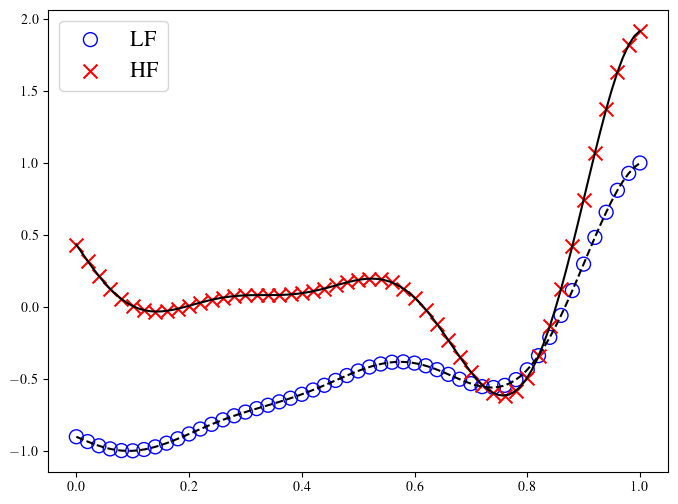

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(x_plot, y_L_plot, '--k')
ax.plot(x_plot, y_H_plot, 'k')
ax.scatter(x_LF[:, 0], x_LF[:, 1], c="none", marker ="o", edgecolor ="blue", s = 100, label='LF')
ax.scatter(x_HF[:, 0], x_HF[:, 1], c="red", marker ="x", s = 100, label='HF')
ax.legend(loc='upper left', fontsize=16)

### Multi-fidelity model

#### Create graph and model instances

In [6]:
# Create the graph
graph_config = {
    'metric': 'euclidean',
    'dist_space': 'ambient',
    'n_components': None,
    'method': 'full',
    'k_nn': None,
    'corr_scale': None,
    'k_adj': 2,
    'p': 0.5,
    'q': 0.5,
}
g_LF = Graph(data=x_LF, **graph_config)

# Create the model 
model_config = {
    'sigma': 0.03,
    'method': 'full',
}
model = MultiFidelityModel(**model_config)

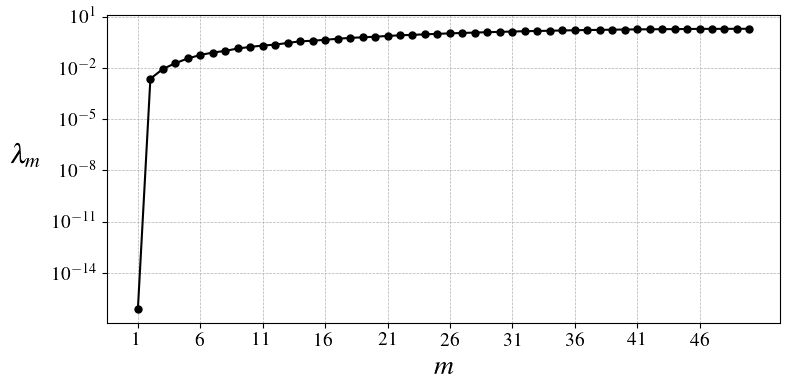

In [7]:
n_HF = 6
inds_train, labels = model.cluster(g_LF, n_HF)

eigvals, eigvecs = g_LF.laplacian_eig()
plot_spectrum(eigvals, 50)

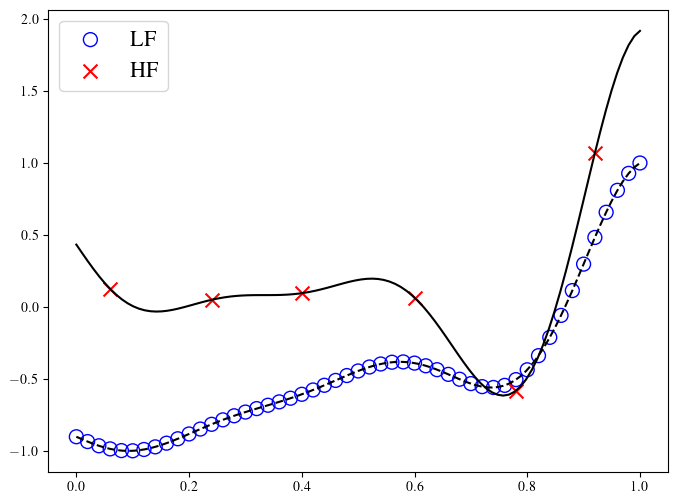

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(x_plot, y_L_plot, '--k')
ax.plot(x_plot, y_H_plot, 'k')
ax.scatter(x_LF[:, 0], x_LF[:, 1], c="none", marker ="o", edgecolor ="blue", s = 100, label='LF')
ax.scatter(x_HF[inds_train, 0], x_HF[inds_train, 1], c="red", marker ="x", s = 100, label='HF')
ax.legend(loc='upper left', fontsize=16)

In [9]:
n_samples = x_HF.shape[0]
inds_test = np.delete(np.arange(n_samples), inds_train)
x_HF_train = x_HF[inds_train, :]
x_HF_test = x_HF[inds_test, :]

print(f"{x_HF_train.shape=}", f"{x_HF_test.shape=}")

x_HF_train.shape=(6, 2) x_HF_test.shape=(45, 2)


#### Fit and train the model

Model Configuration:
sigma                  : 0.03
beta                   : 2
kappa                  : 0.007690233861382903
omega                  : 1460.5000408849055
method                 : full
spectrum_cutoff        : None
tau                    : 0.0022933284974241464
n_clusters             : None
_is_graph_clustered    : False


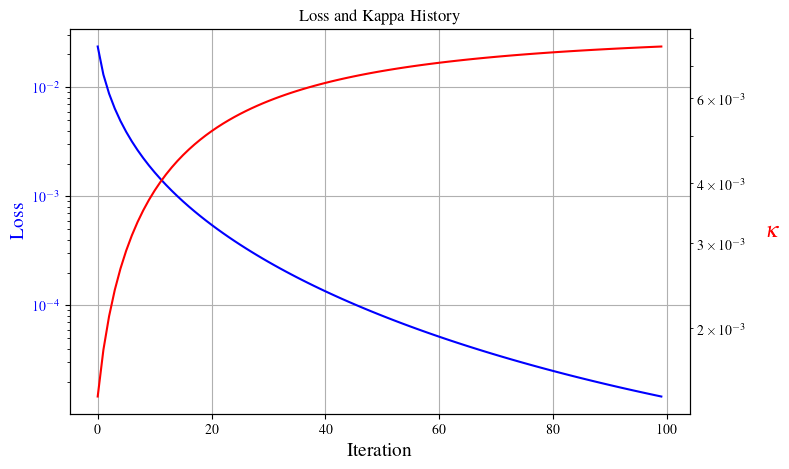

In [25]:
x_MF, C_phi, dPhi, loss_history, kappa_history = model.fit_transform(
    g_LF,
    x_HF_train,
    inds_train,
    maxiter=100,
    step_size=10,
    step_decay_rate=0.99,
    ftol=1e-9,
    verbose=False,
)
model.summary()

iterations = np.arange(len(loss_history))
plot_loss_and_kappa(iterations, loss_history, kappa_history)

### Results

In [20]:
# Error Analysis for the whole dataset
error_analysis(x_LF, x_MF, x_HF)

Mean relative l2 errors and Improvement Factor (IF)
----------------------------------------------------
Error LF:         97.09
Error MF:         11.0
Percentage drop:  88.67%


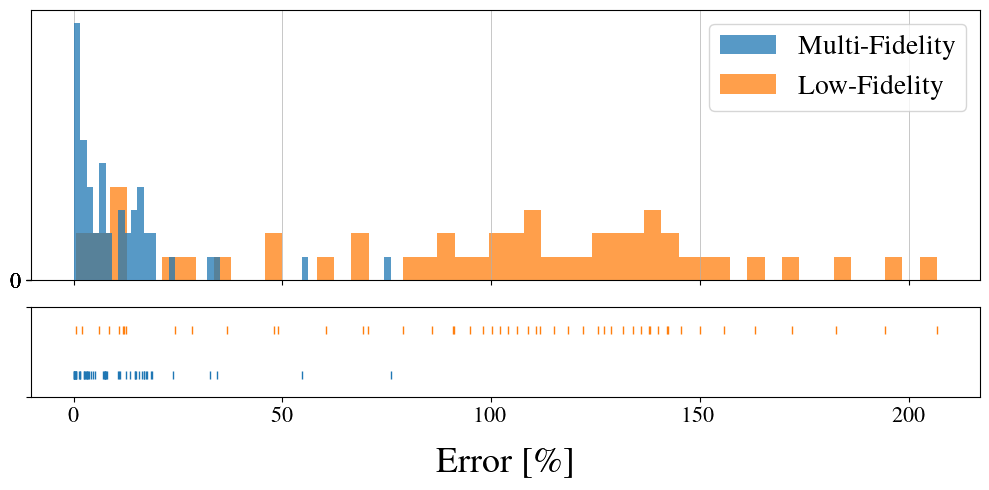

In [23]:
E_LF = 100 * np.linalg.norm(x_LF - x_HF, axis=1) / (np.mean(np.linalg.norm(x_HF, axis=1)) + 1e-3)
E_MF = 100 * np.linalg.norm(x_MF - x_HF, axis=1) / (np.mean(np.linalg.norm(x_HF, axis=1)) + 1e-3)

plot_distributions(E_LF, E_MF, bins_LF=50, bins_MF=50, mask=None)

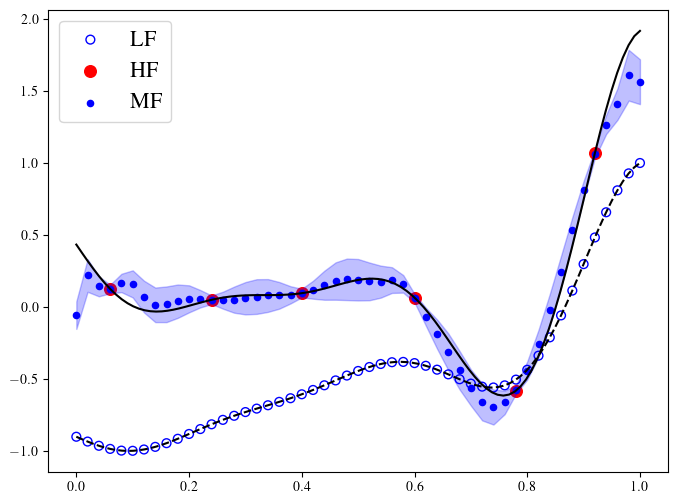

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(x_plot, y_L_plot, '--k')
ax.plot(x_plot, y_H_plot, 'k')
ax.scatter(x_LF[:, 0], x_LF[:, 1], c="none", marker ="o", edgecolor ="blue", s = 40, label='LF')
ax.scatter(x_HF_train[:, 0], x_HF_train[:, 1], c="red", marker ="o", s = 70, label='HF')
ax.scatter(x_MF[:, 0], x_MF[:, 1], c="blue", marker ="o", s = 20, label='MF')
ax.fill_between(x_MF[:, 0], x_MF[:, 1] - dPhi, x_MF[:, 1] + dPhi, color='blue', alpha=0.25)
ax.legend(loc='upper left', fontsize=16)